## NAs

**Import data and chose 5 random participants**

In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read targets
train_events = pd.read_csv('../input/child-mind-institute-detect-sleep-states/train_events.csv')
# Read train data
train_data = dd.read_parquet('../input/child-mind-institute-detect-sleep-states/train_series.parquet', engine='pyarrow')

In [23]:
ids = train_data['series_id'].unique().compute()
ids = np.random.choice(ids, size=5, replace=False)

**Filter out NAs and visualise Anglez evolution**

In [13]:
def delete_NA_from_train_series(train_data, train_events):
    indexes_NA_train_series = []
    
    # Iterate through the train_events dataframe
    i = 0
    while i < len(train_events) - 1:
        current_event = train_events.iloc[i]
        next_event = train_events.iloc[i + 1]
        series_id = next_event['series_id']
        
        # Initialize j to find the next valid timestamp
        j = i + 1
        # If the next event timestamp is NA
        if pd.isna(next_event['timestamp']):
            # Find the next event with a non-NA timestamp, preventing index out-of-bounds
            while j < len(train_events) and pd.isna(train_events.iloc[j]['timestamp']):
                j += 1

            # If we've gone beyond the length of the DataFrame, break
            if j >= len(train_events):
                break
        
            # Grab the next valid event
            next_step = train_events.iloc[j]
            
            # Ensure the series_id is the same before and after the NA block
            if series_id == current_event['series_id'] and series_id == next_step['series_id']:
                # Calculate the time window
                first_time = current_event['timestamp']
                next_time = next_step['timestamp']
                
                # Find indices in train_data between first_time and next_time
                indexes = train_data[
                    (train_data['series_id'] == series_id) &
                    (train_data['timestamp'] > first_time) &
                    (train_data['timestamp'] < next_time)
                ].index
                indexes_NA_train_series.extend(indexes.tolist())
        
        # Move to the next valid event
        i = j
        
    # Drop the collected indices from train_data
    return train_data.drop(set(indexes_NA_train_series))



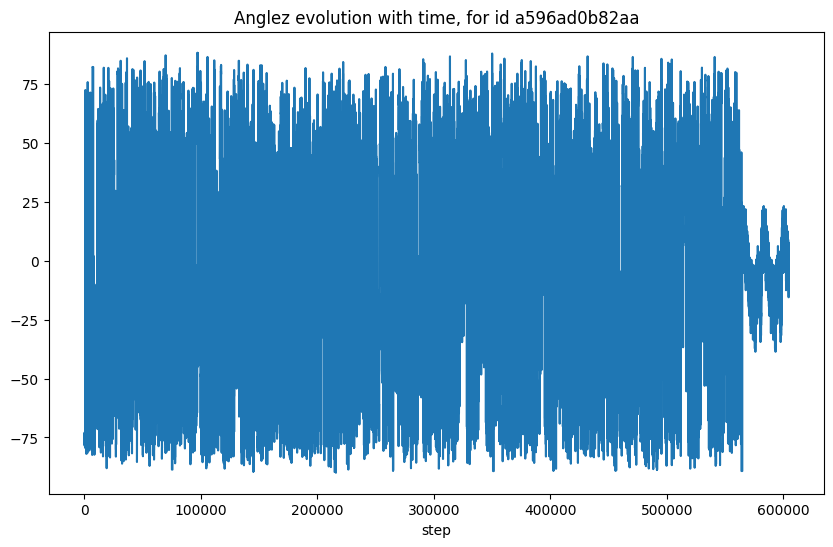

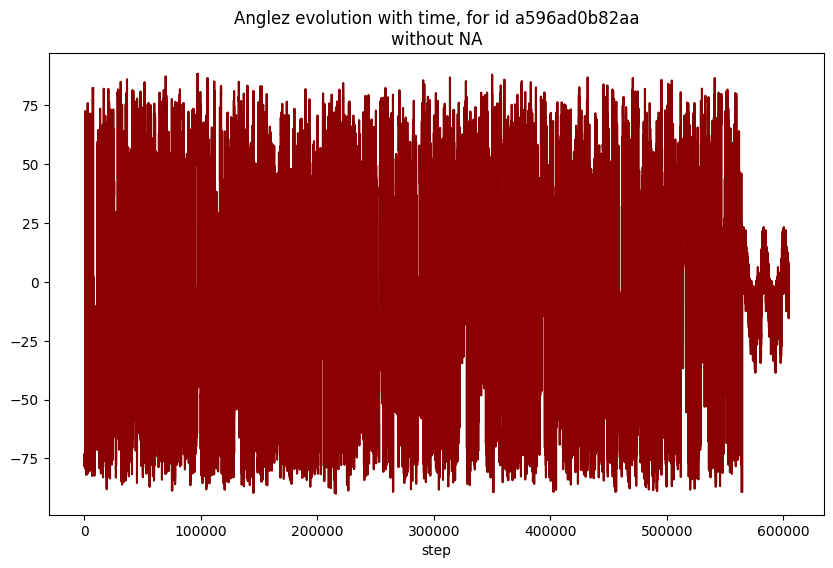

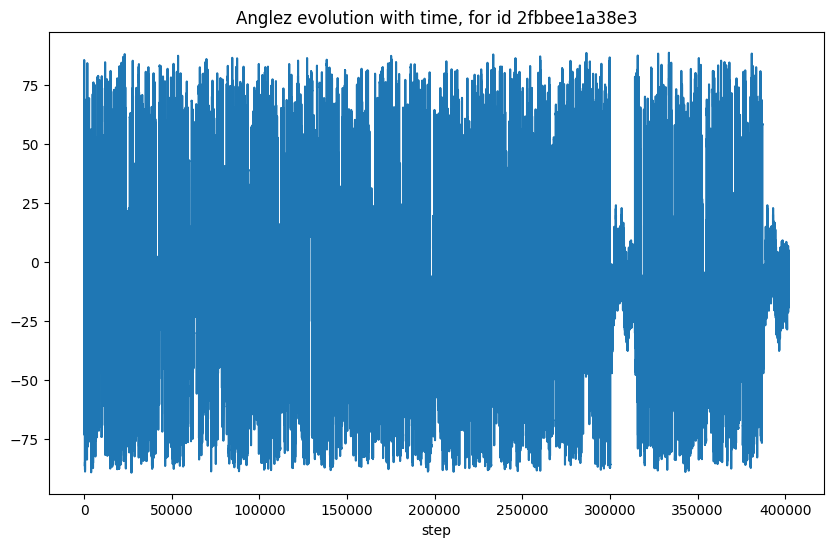

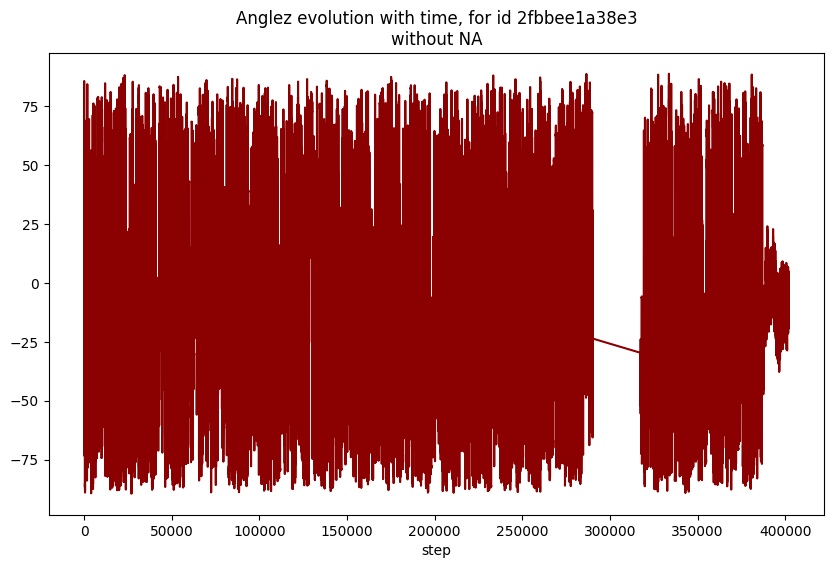

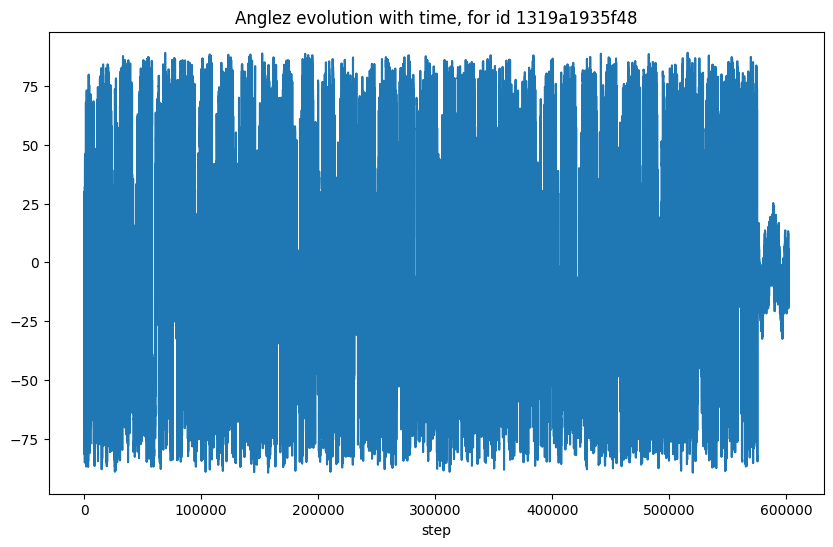

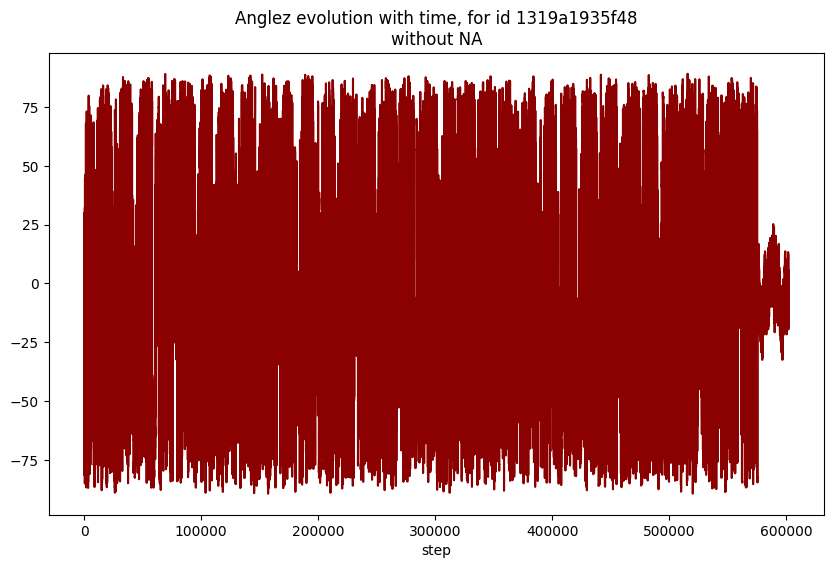

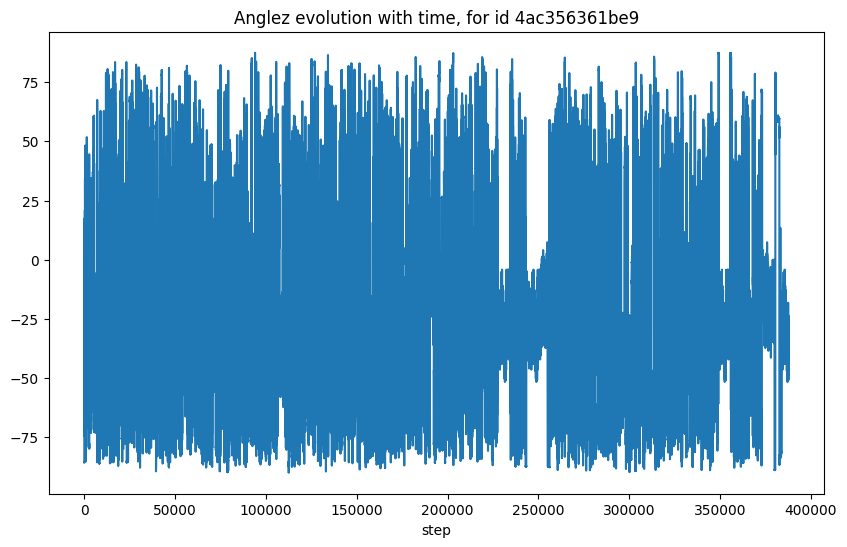

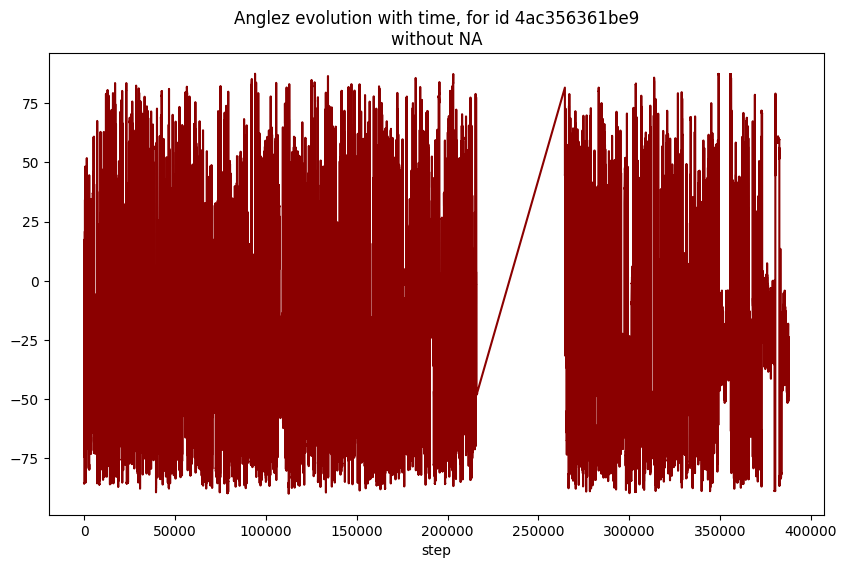

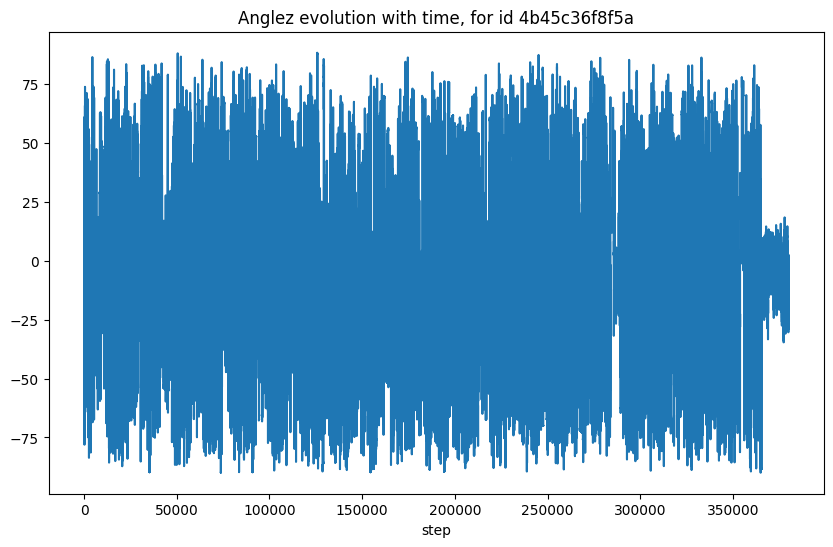

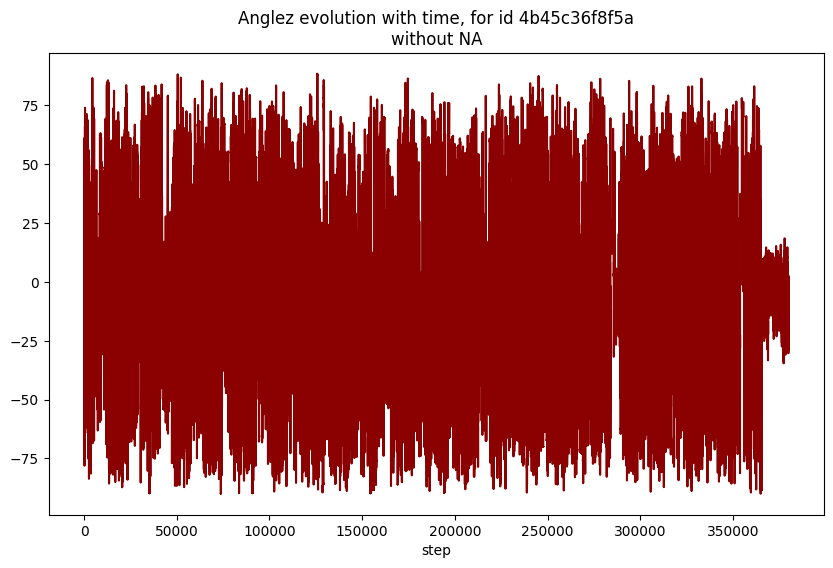

In [29]:
for id in ids:
    sample_data = train_data.loc[train_data['series_id'] == id].compute()
    plt.figure(figsize=(10, 6))
    plt.plot(sample_data['step'], sample_data['anglez'])
    plt.xlabel("step")
    plt.title(f"Anglez evolution with time, for id {id}")
    plt.show()
    
    sample_data_no_NA = delete_NA_from_train_series(sample_data, train_events)
    plt.figure(figsize=(10, 6))
    plt.plot(sample_data_no_NA['step'], sample_data_no_NA['anglez'],
            color='darkred')
    plt.xlabel("step")
    plt.title(f"Anglez evolution with time, for id {id}\nwithout NA")
    plt.show()


**Filter out NAs and visualise Enmo distribution**

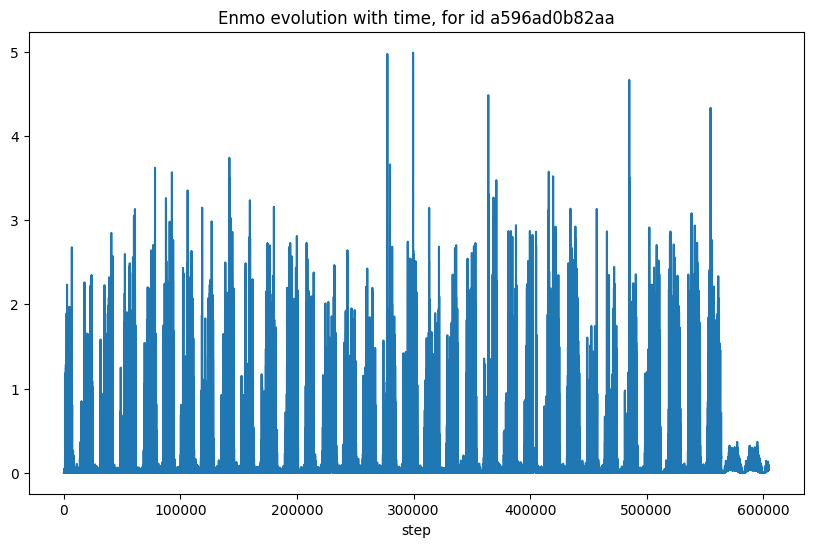

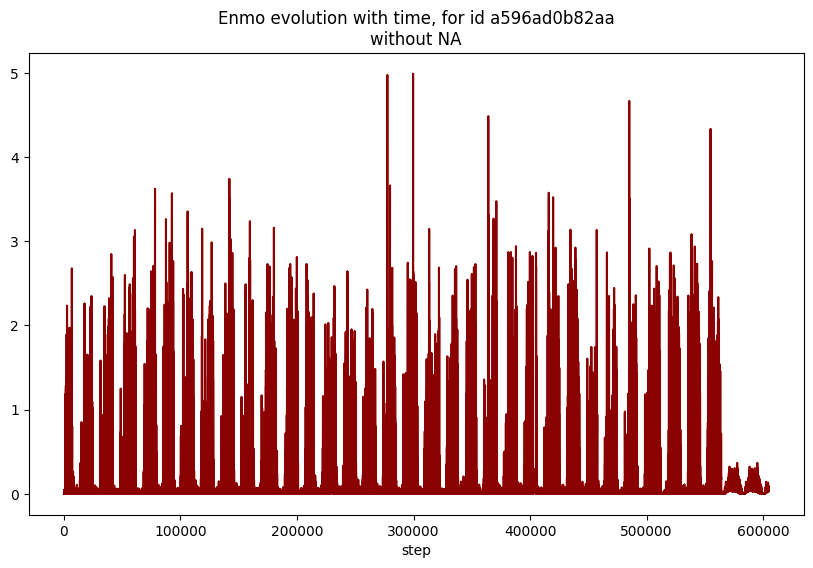

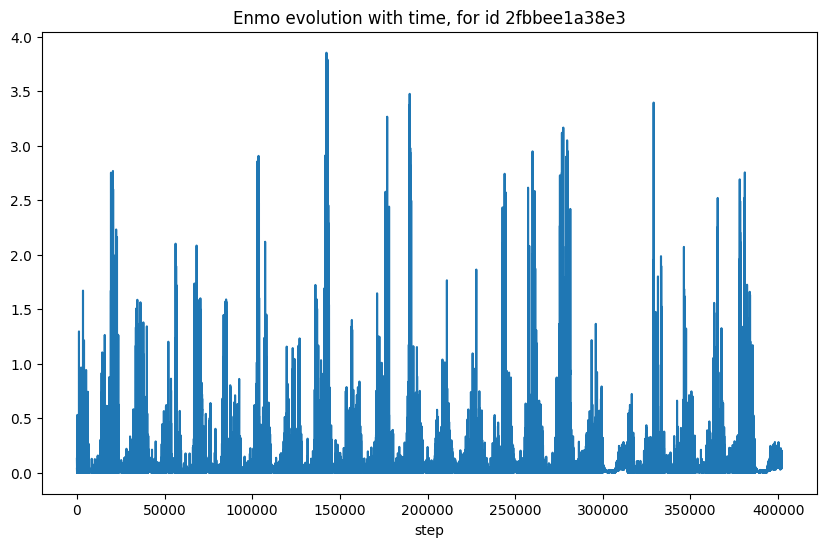

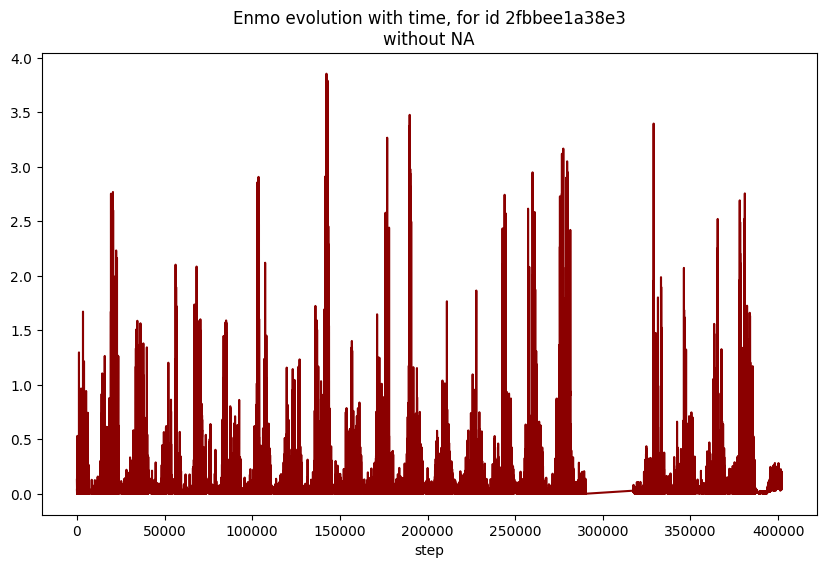

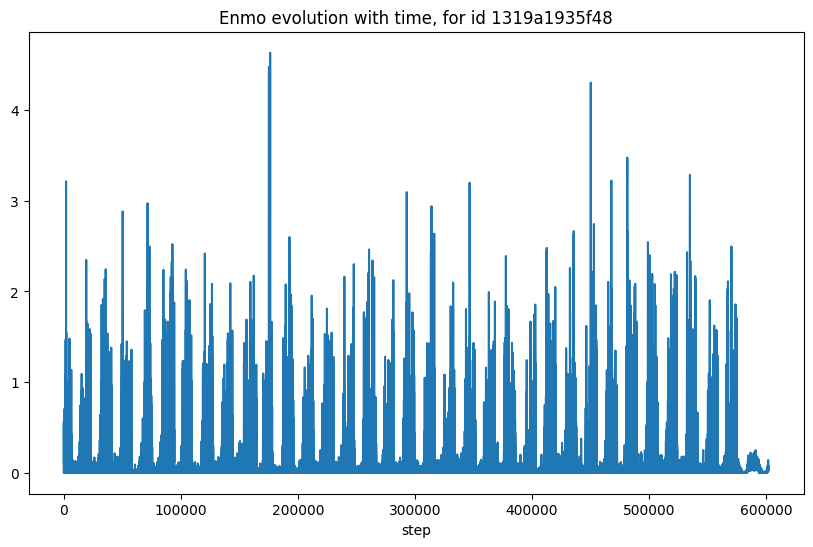

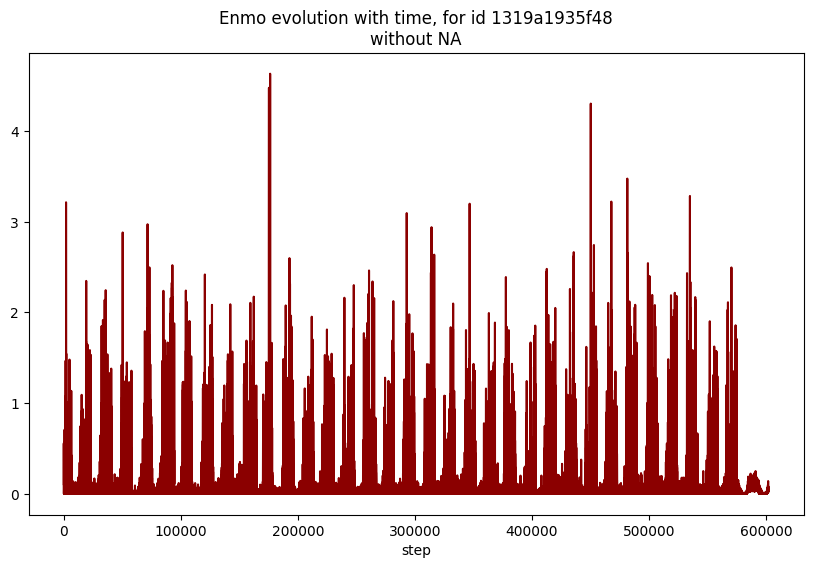

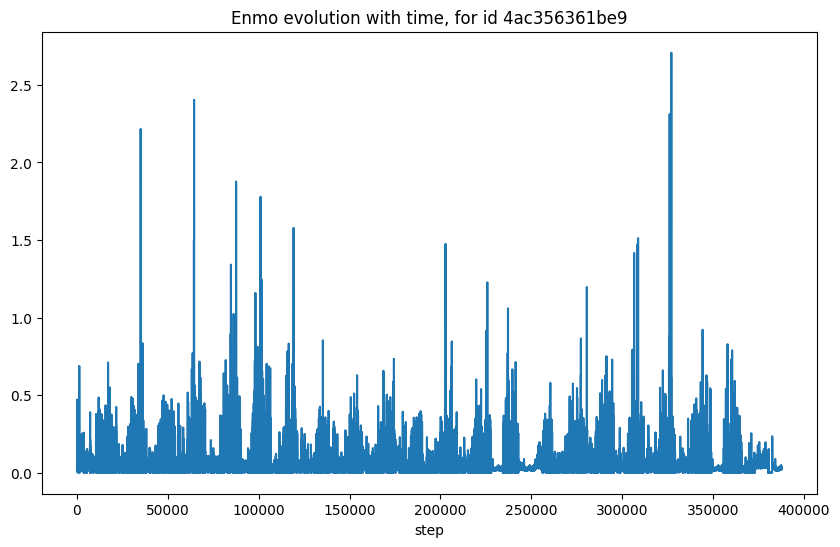

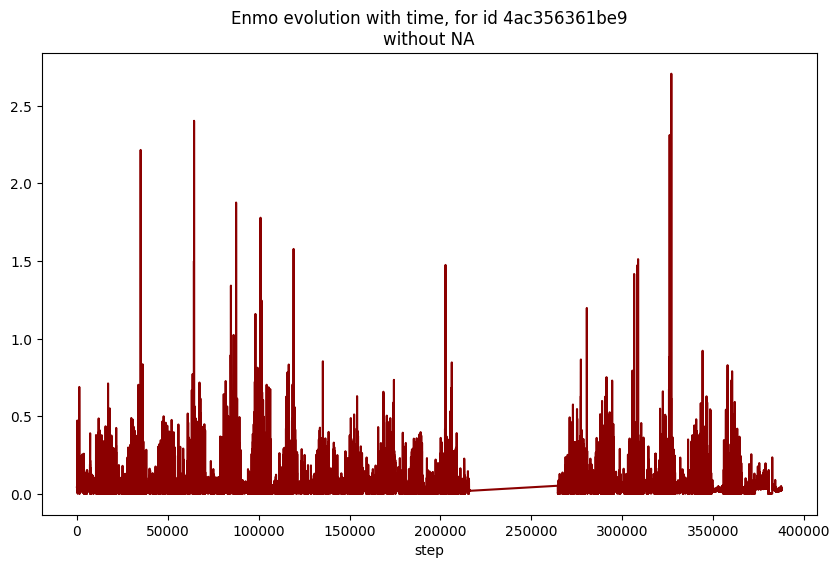

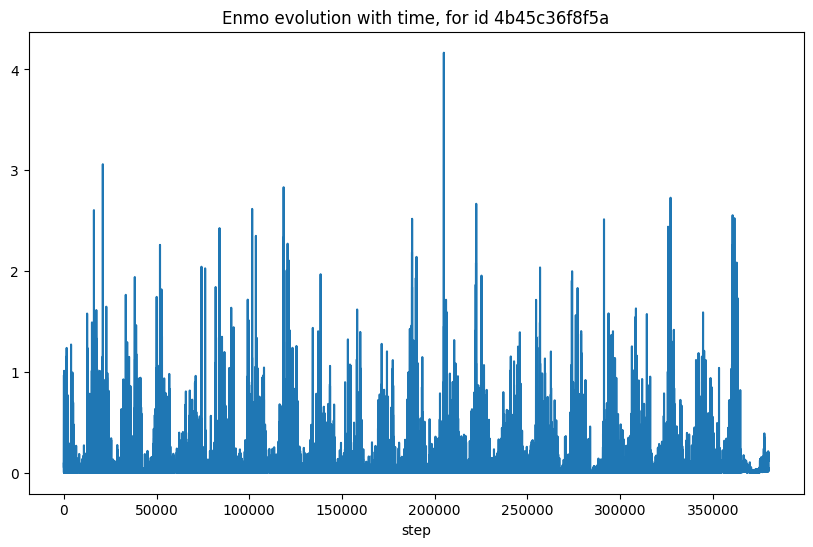

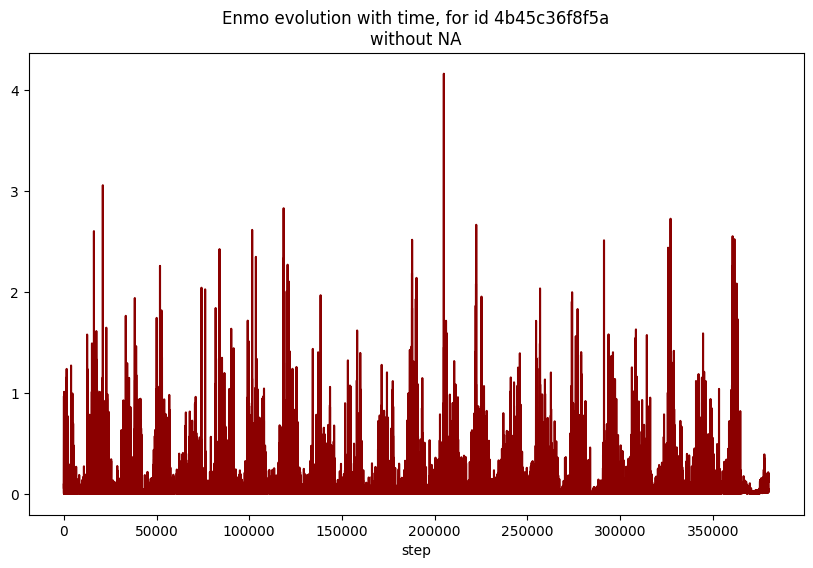

In [30]:
for id in ids:
    sample_data = train_data.loc[train_data['series_id'] == id].compute()
    plt.figure(figsize=(10, 6))
    plt.plot(sample_data['step'], sample_data['enmo'])
    plt.xlabel("step")
    plt.title(f"Enmo evolution with time, for id {id}")
    plt.show()
    
    sample_data_no_NA = delete_NA_from_train_series(sample_data, train_events)
    plt.figure(figsize=(10, 6))
    plt.plot(sample_data_no_NA['step'], sample_data_no_NA['enmo'],
            color='darkred')
    plt.xlabel("step")
    plt.title(f"Enmo evolution with time, for id {id}\nwithout NA")
    plt.show()

## Series tails

**Filter last 5% and visualise distributions for Enmo and Anglez**

In [66]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
max_steps = pd.read_csv('../data/max_steps.csv')
train_data = dd.read_parquet('../data/train_series.parquet', engine='pyarrow')
train_data_head = train_data.head(500000, compute=True)

In [69]:
def filter_last_percents(train_series, max_steps):
    # Add the min step from which to drop rows
    max_steps["min_step"] = (max_steps["step"] - max_steps["step"] * 0.05).round()
    
    # Initialize an empty set to store indices to filter out
    indices_to_drop = set()
    # Step through each row in max_steps DataFrame
    for _, row in max_steps.iterrows():
        series_id = row['series_id']
        min_step = row['min_step']
        step = row['step']
        # Find indices in train_series that match the condition
        condition = (train_series['series_id'] == series_id) & (train_series['step'] >= min_step) & (train_series['step'] <= step)
        # Add indices to the set of indices to drop
        indices_to_drop.update(train_series[condition].index)

    # Drop the identified indices from train_series
    filtered_train_series = train_series.drop(index=indices_to_drop)
    return filtered_train_series

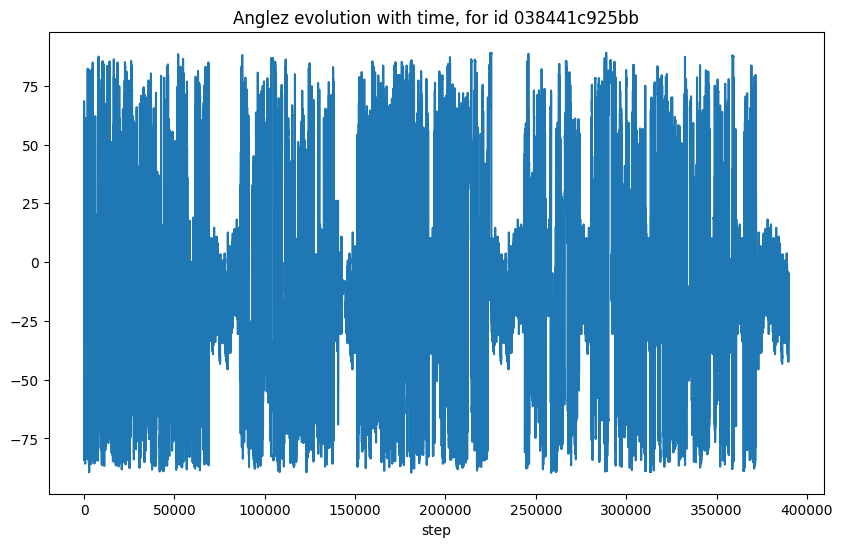

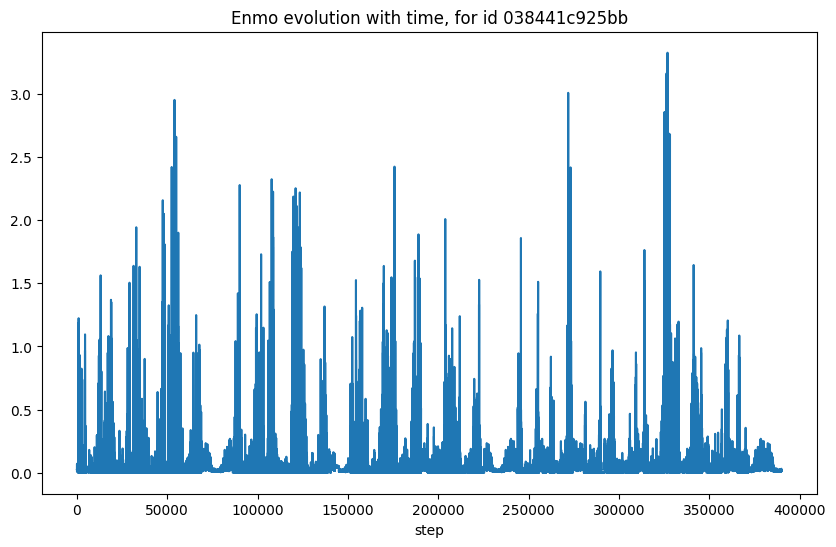

In [70]:
id = train_data_head.loc[1, "series_id"]
data = train_data_head[train_data_head["series_id"] == id]
plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['anglez'])
plt.xlabel("step")
plt.title(f"Anglez evolution with time, for id {id}")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['enmo'])
plt.xlabel("step")
plt.title(f"Enmo evolution with time, for id {id}")
plt.show()

In [71]:
train_data_head = filter_last_percents(train_data_head, max_steps)

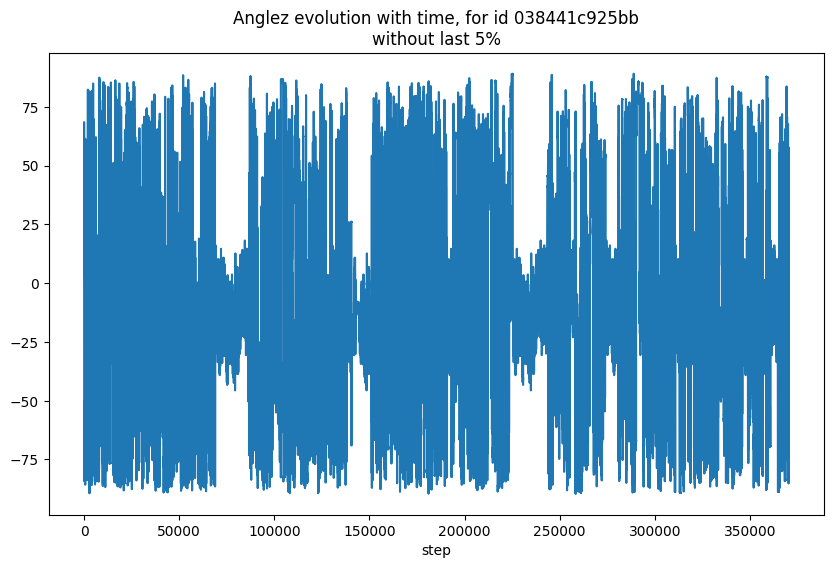

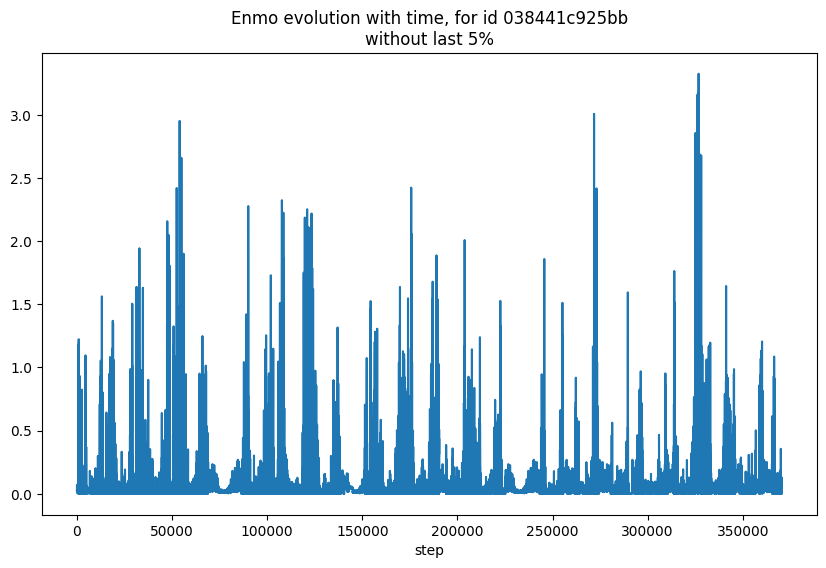

In [72]:
id = train_data_head.loc[1, "series_id"]
data = train_data_head[train_data_head["series_id"] == id]
plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['anglez'])
plt.xlabel("step")
plt.title(f"Anglez evolution with time, for id {id}\nwithout last 5%")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['enmo'])
plt.xlabel("step")
plt.title(f"Enmo evolution with time, for id {id}\nwithout last 5%")
plt.show()